In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

In [7]:
class Solution(object):
    """
    minimize/maximize:   f(x) = x.T @ G @ x / 2 + x.T @ g + c
    subject to  Ax >= b
    
    if G is positive definite matrix, use ActiveSetMethod to maximize
    if G is negative definite matrix, use ActiveSetMethod to minimize
    """
    def __init__(self, G, g, c):
        self.G = G
        self.g = g
        self.c = c
    
    def fX(self, x: np.ndarray) -> float:
        return x.T @ self.G @ x / 2 + x.T @ self.g + self.c
    
    def gradient(self, x: np.ndarray) -> np.ndarray:
        return self.G @ x + self.g
    
    @staticmethod
    def cal_p(G, g, A):
        A = A.T
        S = np.zeros((A.shape[1] + G.shape[0], A.shape[1] + G.shape[1]))
        S[:G.shape[0], :G.shape[1]] = -G
        S[:G.shape[0], G.shape[1]:] = A
        S[G.shape[0]:, :G.shape[1]] = A.T
        p = np.linalg.solve(S, np.concatenate(
                (g, np.zeros((A.shape[1], 1))), axis=0)
            )
        return p[:G.shape[1]], p[G.shape[1]:]
    
    def ActiveSetMethod(self, x: np.ndarray):
        W = np.array([(self.A[i] @ x == self.b[i])[0] 
                      for i in range(self.A.shape[0])])
        while True:
            p, lambdas = self.cal_p(self.G, self.G @ x + self.g, self.A[W])
            print(f'p: {p.flatten().tolist()}, lambdas: {lambdas.flatten().tolist()}')
            print(f'W: {W.flatten().tolist()}, x: {x.flatten().tolist()}')
            if np.all(abs(p) < 1e-6):
                if np.all(lambdas >= 0):
                    return x, self.fX(x)
                else:
                    j = np.argmin(lambdas)
                    W[np.where(W == 1)[0][j]] = False
            else:
                alpha = np.inf
                alpha_idx = []
                for i in range(len(W)):
                    if W[i] == False and (self.A[i] @ p)[0] < 0:
                        k = (self.b[i] - self.A[i].T @ x)[0] / (self.A[i].T @ p)[0]
                        if k < alpha:
                            alpha = k
                            alpha_idx = [i]
                        elif k == alpha:
                            alpha_idx.append(i)    
                if alpha >= 1:
                    x = x + p
                else:
                    x = x + alpha * p
                    for i in alpha_idx:
                        W[i] = True
    
    def maximize(self, A, b, x0):
        """
        here self.G must be negative definite matrix
        """
        self.A = A
        self.b = b
        self.G, self.g, self.c = -self.G, -self.g, -self.c
        x, f = self.ActiveSetMethod(x0)
        self.G, self.g, self.c = -self.G, -self.g, -self.c
        return x.flatten().tolist(), -f[0, 0]
    
    def minimize(self, A, b, x0):
        """
        here self.G must be positive definite matrix
        """
        self.A = A
        self.b = b
        x, f = self.ActiveSetMethod(x0)
        return x.flatten().tolist(), f[0, 0]

In [8]:
def GraphicalMethod():
    """
    Graphical method to visualize the feasible region and the constraints.
    """
    def f(x1, x2):
        return 6 * x1 + 4 * x2 - 13 - x1 ** 2 - x2 ** 2
    x1 = np.linspace(0, 3, 100)
    x2 = np.linspace(0, 3, 100)
    X1, X2 = np.meshgrid(x1, x2)
    Z = f(X1, X2)
    
    plt.figure(figsize=(8, 6))
    contour = plt.contour(X1, X2, Z, levels=30, cmap='viridis')
    plt.colorbar(contour)

    x1_constraint = np.linspace(0, 3, 100)
    x2_constraint = 3 - x1_constraint
    plt.plot(x1_constraint, x2_constraint, label='x1 + x2 <= 3', color='red')
    plt.fill_between(x1_constraint, 0, x2_constraint, alpha=0.2, color='red')
    
    plt.axvline(x=0, color='black', lw=1)
    plt.axhline(y=0, color='black', lw=1)
    
    plt.fill_between(x1_constraint, 0, x2_constraint, where=(x1_constraint >= 0) & (x2_constraint >= 0), alpha=0.3, color='red')
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(0, 3)
    plt.ylim(0, 3)
    plt.legend()
    plt.grid(True)
    plt.show()

## 第五题

p: [2.0, 1.0], lambdas: []
W: [False, False, False], x: [1, 1]
p: [0.3333333333333335, -0.33333333333333326], lambdas: [2.0]
W: [True, False, False], x: [1.6666666666666665, 1.3333333333333333]
p: [-0.0, -0.0], lambdas: [2.0]
W: [True, False, False], x: [2.0, 1.0]
x_star: [2.0, 1.0], max_value: -2.0


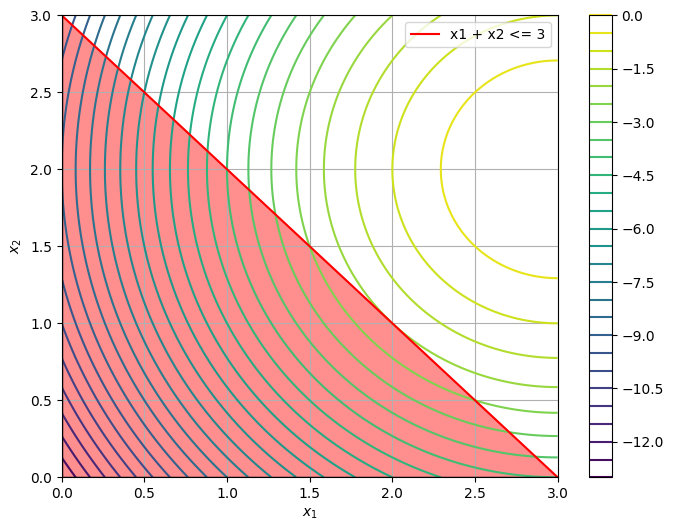

In [9]:
def main5():
    G = np.array([
        [-2, 0],
        [0, -2]
    ])
    g = np.array([[6, 4]]).T
    c = -13
    A = np.array([
        [-1, -1], # x1 + x2 <= 3
        [1, 0], # x1 >= 0
        [0, 1], # x2 >= 0
    ])
    b = np.array([[-3, 0, 0]]).T
    x0 = np.array([[1, 1]]).T
    solution = Solution(G, g, c)
    x_star, max_value = solution.maximize(A, b, x0)
    print(f'x_star: {x_star}, max_value: {max_value}')

main5()
GraphicalMethod()

## 第六题

In [10]:
def main6():
    G = np.array([
        [2, -2],
        [-2, 4]
    ])
    g = np.array([[-2, -6]]).T
    c = -2
    A = np.array([
        [-1, -1], # x1 + x2 <= 2
        [1,  -2], # x1 - 2 * x2 >= -2
        [1, 0], # x1 >= 0
        [0, 1], # x2 >= 0
    ])
    b = np.array([[-2, -2, 0, 0]]).T
    x0 = np.array([[1, 0]]).T
    solution = Solution(G, g, c)
    x_star, min_value = solution.minimize(A, b, x0)
    print(f'x_star: {np.round(x_star, 4)}, min_value: {min_value:.4f}')


main6()

p: [-0.0, -0.0], lambdas: [-8.0]
W: [False, False, False, True], x: [1, 0]
p: [4.0, 4.0], lambdas: []
W: [False, False, False, False], x: [1, 0]
p: [-0.6999999999999997, 0.7000000000000002], lambdas: [2.8]
W: [True, False, False, False], x: [1.5, 0.5]
p: [-0.0, -0.0], lambdas: [2.8]
W: [True, False, False, False], x: [0.8000000000000003, 1.2000000000000002]
x_star: [0.8 1.2], min_value: -9.2000
